In [5]:
import cv2
import mediapipe as mp
import os
import pandas as pd
from tqdm import tqdm

# Set paths
image_dir = r"G:/zolo/classroom-attention-monitor/datasets/pose/dataset/train/images"
label_dir = r"G:/zolo/classroom-attention-monitor/datasets/pose/dataset/train/labels"

# MediaPipe pose setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

# Initialize result list
data = []

# Process each image
for img_name in tqdm(os.listdir(image_dir)):
    if not img_name.endswith('.jpg'):
        continue

    image_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt"))

    # Read label file
    if not os.path.exists(label_path):
        continue  # Skip if label not found

    with open(label_path, "r") as f:
        label_line = f.readline().strip()
        if not label_line:
            continue
        label = int(label_line.split()[0])  # class index (0/1/2)

    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Process with MediaPipe
    result = pose.process(img_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        row = []
        for lm in landmarks:
            row.extend([lm.x, lm.y, lm.visibility])
        row.append(label)
        row.append(img_name)
        data.append(row)

# Create DataFrame
num_landmarks = 33 * 3
columns = [f"{axis}{i}" for i in range(33) for axis in ['x', 'y', 'v']]
columns += ['label', 'image']
df = pd.DataFrame(data, columns=columns)

# Save to CSV
output_csv = r"G:/zolo/classroom-attention-monitor/datasets/pose/dataset/pose_landmarks_labeled.csv"
df.to_csv(output_csv, index=False)

print("✅ Landmark data saved:", output_csv)
df.head()


  0%|          | 0/3396 [00:00<?, ?it/s]

100%|██████████| 3396/3396 [02:00<00:00, 28.19it/s] 


✅ Landmark data saved: G:/zolo/classroom-attention-monitor/datasets/pose/dataset/pose_landmarks_labeled.csv


,x0,y0,v0,x1,y1,v1,x2,y2,v2,x3,...,y30,v30,x31,y31,v31,x32,y32,v32,label,image
0,0.475269,0.411590,0.999491,0.503531,0.347425,0.999476,0.535709,0.346622,0.999416,0.566568,...,3.538356,0.000478,0.819535,3.667345,0.000137,0.489474,3.684901,0.000298,0,attention_MOV-0002_jpg.rf.9443733337591923692e...
1,0.470390,0.417791,0.999125,0.501382,0.353185,0.999146,0.535834,0.353199,0.999122,0.568480,...,3.593280,0.000213,0.772428,3.702159,0.000160,0.441848,3.716429,0.000187,0,attention_MOV-0003_jpg.rf.a54bed6a920af39a66ef...
2,0.462133,0.416705,0.998469,0.491382,0.340692,0.996088,0.526962,0.336577,0.997309,0.560594,...,3.663785,0.000025,1.055309,3.748930,0.000037,0.722253,3.787668,0.000027,0,attention_MOV-0004_jpg.rf.85a121fd471ea6f9df25...
3,0.467665,0.412785,0.995297,0.500829,0.351339,0.994144,0.535899,0.352966,0.995190,0.569863,...,3.580585,0.000057,0.777514,3.711236,0.000071,0.435301,3.715485,0.000077,0,attention_MOV-0004_jpg.rf.c0431efd9cd3deda8287...
4,0.461026,0.403652,0.999018,0.489797,0.346941,0.998925,0.520340,0.347488,0.998838,0.552871,...,3.535843,0.000197,0.815692,3.640632,0.000143,0.483311,3.664359,0.000205,0,attention_MOV-0005_jpg.rf.34d3df7b3b47369ae083...


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       179
           1       0.94      0.96      0.95       231

    accuracy                           0.94       410
   macro avg       0.94      0.94      0.94       410
weighted avg       0.94      0.94      0.94       410



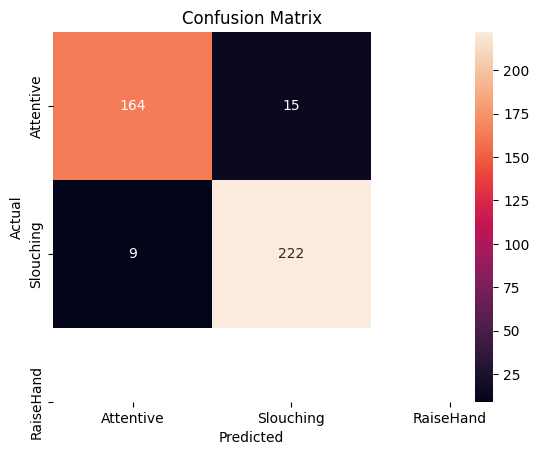

✅ Model saved at: G:/zolo/classroom-attention-monitor//models/pose_model.pkl


In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV
csv_path = r"G:/zolo/classroom-attention-monitor/datasets/pose/dataset/pose_landmarks_labeled.csv"
df = pd.read_csv(csv_path)

# Drop any rows with missing values (just in case)
df.dropna(inplace=True)

# Split features and labels
X = df.drop(['label', 'image'], axis=1)
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Attentive', 'Slouching', 'RaiseHand'], yticklabels=['Attentive', 'Slouching', 'RaiseHand'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save the model
model_path = r"G:/zolo/classroom-attention-monitor//models/pose_model.pkl"
joblib.dump(model, model_path)
print("✅ Model saved at:", model_path)
